In [1]:
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## About dataset

- Age : Age of the patient

- Sex : Sex of the patient

- exang: exercise induced angina (1 = yes; 0 = no)

- ca: number of major vessels (0-3)

- cp : Chest Pain type chest pain type
     - Value 1: typical angina
     - Value 2: atypical angina
     - Value 3: non-anginal pain
     - Value 4: asymptomatic
     
- trestbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
    
- thalach : maximum heart rate achieved
- target : 0= less chance of heart attack 1= more chance of heart attack

In [72]:
df = pd.read_csv('../Data/heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [3]:
pp.ProfileReport(df)

In [4]:
df.shape

(303, 14)

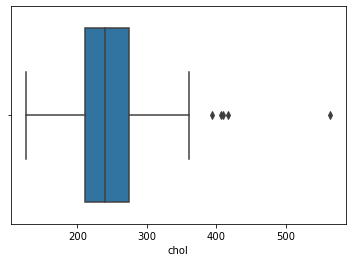

In [5]:
_ = sns.boxplot(x='chol', data=df)

In [73]:
df = df[df.chol<380]
df = df[df.trestbps<190]
df = df[df.thalach>75]

In [7]:
df.shape

(295, 14)

In [104]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [100]:
X = df.drop('target', axis = 1)
y = df.target
X = StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=10)

In [105]:
#itterating to find the best k value
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.72881356, 0.71186441, 0.83050847, 0.79661017, 0.83050847,
       0.83050847, 0.81355932, 0.84745763, 0.81355932, 0.83050847,
       0.83050847, 0.83050847, 0.83050847, 0.83050847, 0.81355932,
       0.83050847, 0.83050847, 0.83050847, 0.84745763, 0.84745763,
       0.84745763, 0.84745763, 0.84745763, 0.86440678, 0.86440678,
       0.86440678, 0.86440678, 0.86440678, 0.86440678])

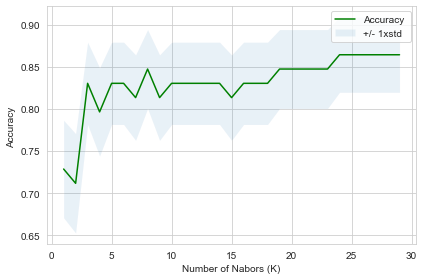

In [106]:
#Plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10) #showing 68% data
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [12]:
scores=[]
best_estimators = {}


model_params = {  
    
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01,0.02,0.03],
            'n_estimators' : [23,24,25,26,27],
            'max_depth' : [13,14,15,16,17],
            'gamma' : [0.05,0.06,0.07],
            'subsample' : [0.5,0.51,0.52,0.53,0.54,0.55],
            'colsample_bytree' : [0.55,0.6,0.65],
            'seed' : [26,27,28],
             'reg_lambda' : [1,2,3],
            'booster' : ['dart'],
            'colsample_bylevel' : [0]
        }
    },
    
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [2,3,4,5,6,7,18,19,20,21,22,23,24],
            'algorithm' : ['auto','ball_tree','kd_tree'],
            'weights' : ['uniform','distance'],
            'leaf_size' : [27,28,29,30,31,32,33,34,35]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth' : [None,1,2,6,5,4,3]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [30,35,40,45,50,55,58,60,65,70],
            'learning_rate' : [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(),
        'params': {
            'C': [1,2,3,4,5,6,7,8,9,10],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [1,2,3,5,6,7],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[1,2,3,4,5,10,15,20,25,30],
            'criterion': ['entropy'],
            'random_state' : [11,12,13],
            'max_depth' : [4,5,6]

        }
    }
}

In [13]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None) {'learning_rate': [0.01, 0.02, 0.03], 'n_estimators': [23, 24, 25, 26, 27], 'max_depth': [13, 14, 15, 16, 17], 'gamma': [0.05, 0.06, 0.07], 'subsample': [0.5, 0.51, 0.52, 0.53, 0.54, 0.55], 'colsample_bytree': [0.55, 0.6, 0.65], 'seed': [26, 27, 28], 'reg_lambda': [1, 2, 3], 'booster': ['dart'], 'colsample_bylevel': [0]}
31.14911692539851 minutes
KNeighborsClassifie

In [14]:
import pandas as pd    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2 = df2.sort_values(by='best_score',ascending=False)
df2

model  best_score  \
0                 XGBoost    0.860195   
7           RANDOM_FOREST    0.843174   
3      AdaBoostClassifier    0.834574   
1    KNeighborsClassifier    0.826064   
4              GaussianNB    0.817819   
2  DecisionTreeClassifier    0.817730   
6                     SVM    0.813387   
5     LOGISTIC_REGRESSION    0.796365   

                                         best_params  
0  {'booster': 'dart', 'colsample_bylevel': 0, 'c...  
7  {'criterion': 'entropy', 'max_depth': 4, 'n_es...  
3  {'algorithm': 'SAMME', 'learning_rate': 0.8, '...  
1  {'algorithm': 'auto', 'leaf_size': 27, 'n_neig...  
4                                                 {}  
2           {'criterion': 'entropy', 'max_depth': 3}  
6      {'C': 2, 'gamma': 'auto', 'kernel': 'linear'}  
5  {'C': 1, 'multi_class': 'auto', 'solver': 'lib...

In [16]:
df2.best_params[0]

"{'booster': 'dart', 'colsample_bylevel': 0, 'colsample_bytree': 0.65, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 13, 'n_estimators': 23, 'reg_lambda': 1, 'seed': 27, 'subsample': 0.5}"

In [117]:
cross_val_score(best_estimators['XGBoost'],X_test,y_test,cv=5).mean()

0.8318181818181818

In [118]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_test,y_test,cv=5).mean()

0.865151515151515

In [119]:
cross_val_score(best_estimators['KNeighborsClassifier'],X_test,y_test,cv=5).mean()

0.8318181818181817

In [120]:
cross_val_score(best_estimators['GaussianNB'],X_test,y_test,cv=5).mean()

0.7787878787878787

In [121]:
cross_val_score(best_estimators['DecisionTreeClassifier'],X_test,y_test,cv=5).mean()

0.7636363636363637

In [122]:
cross_val_score(best_estimators['SVM'],X_test,y_test,cv=5).mean()

0.7969696969696971

In [123]:
cross_val_score(best_estimators['LOGISTIC_REGRESSION'],X_test,y_test,cv=5).mean()

0.7818181818181819

In [124]:
cross_val_score(best_estimators['AdaBoostClassifier'],X_test,y_test,cv=5).mean()

0.7803030303030304

In [51]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25,
                       random_state=13)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.63      0.76        27
           1       0.76      0.97      0.85        32

    accuracy                           0.81        59
   macro avg       0.85      0.80      0.80        59
weighted avg       0.84      0.81      0.81        59



In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[17, 10],
       [ 1, 31]], dtype=int64)

In [55]:
class_dict = {'Normal':0, 'Prone to heart attack':1}

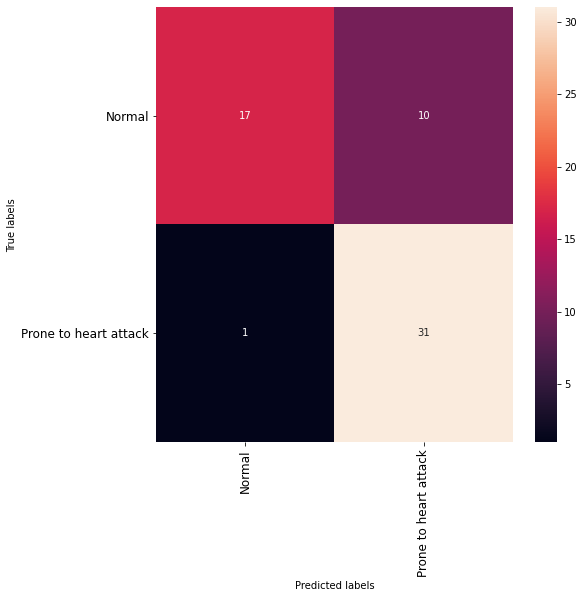

In [56]:
fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(cm,annot=True,ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
ax.xaxis.set_ticklabels(class_dict.keys()); ax.yaxis.set_ticklabels(class_dict.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

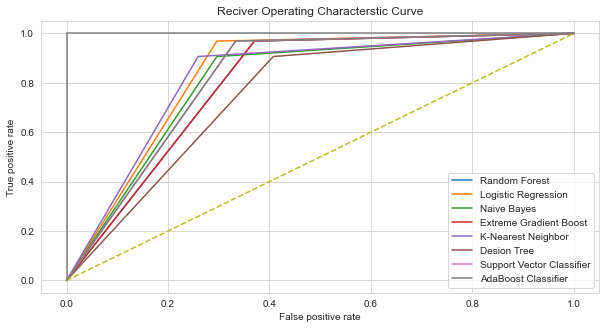

In [112]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = metrics.roc_curve(y_test,best_estimators['LOGISTIC_REGRESSION'].predict(X_test))
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = metrics.roc_curve(y_test,best_estimators['GaussianNB'].predict(X_test))
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = metrics.roc_curve(y_test,best_estimators['RANDOM_FOREST'].predict(X_test))                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = metrics.roc_curve(y_test,best_estimators['XGBoost'].predict(X_test))
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = metrics.roc_curve(y_test,best_estimators['KNeighborsClassifier'].predict(X_test))
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = metrics.roc_curve(y_test,best_estimators['DecisionTreeClassifier'].predict(X_test))
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = metrics.roc_curve(y_test,best_estimators['SVM'].predict(X_test))
ada_false_positive_rate,ada_true_positive_rate,ada_threshold = metrics.roc_curve(y_test,best_estimators['AdaBoostClassifier'].predict(X_test))


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(ada_false_positive_rate,ada_true_positive_rate,label='AdaBoost Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

C:\Users\Notebook\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  import sys


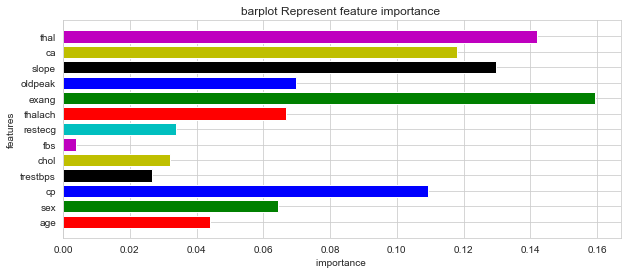

In [90]:
imp_feature = pd.DataFrame({'Feature': ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'], 'Importance': best_estimators['XGBoost'].feature_importances_})
plt.figure(figsize=(10,4))
plt.title("barplot Represent feature importance ")
plt.xlabel("importance ")
plt.ylabel("features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')
plt.show()

In [80]:
X = df.drop('target', axis = 1)
y = df.target

from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('RandomForest', RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25,
                       random_state=13))])

pipe.fit(X,y)



Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        n_estimators=25, random_state=13))])

In [81]:
import joblib 
joblib.dump(pipe, 'heart_saved_model.pkl')

['heart_saved_model.pkl']

In [82]:
import json
with open("heart_class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [92]:
test = np.array([41,0,1,130,204,0,0,172,0,1.4,2,0,2])
pipe.predict(test.reshape(1,-1))

array([1], dtype=int64)